In [ ]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
SAMPLE_RATE = 48000
file_path = "/content/03-01-08-02-02-01-23.wav"
mel_spectrograms = []
signals = []
audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
signals.append(signal)
signals = np.stack(signals,axis=0)
X_train = signals

MEL spectrogram shape:  (128, 563)


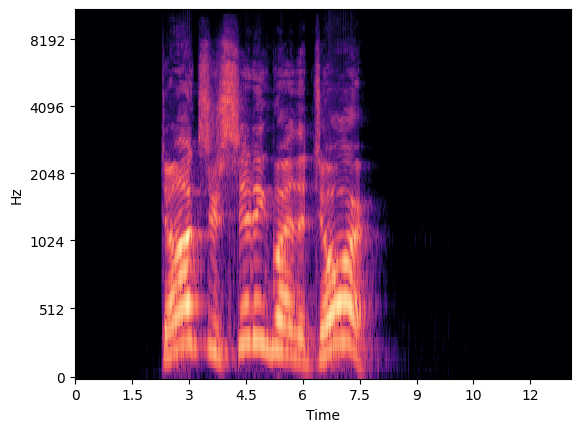

In [ ]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [ ]:
def splitIntoChunks(mel_spec,win_size,stride):
    t = mel_spec.shape[1]
    num_of_chunks = int(t/stride)
    chunks = []
    for i in range(num_of_chunks):
        chunk = mel_spec[:,i*stride:i*stride+win_size]
        if chunk.shape[1] == win_size:
            chunks.append(chunk)
    return np.stack(chunks,axis=0)

In [ ]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')

Calculatin mel spectrograms for train set
 Processed 0/1 files

In [ ]:
mel_train_chunked = []
for mel_spec in mel_train:
    chunks = splitIntoChunks(mel_spec, win_size=128,stride=64)
    mel_train_chunked.append(chunks)

In [ ]:
X_train = np.stack(mel_train_chunked,axis=0)
X_train = np.expand_dims(X_train,2)
print('Shape of X_train: ',X_train.shape)

Shape of X_train:  (1, 7, 1, 128, 128)


In [ ]:
import torch
import torch.nn as nn
# BATCH FIRST TimeDistributed layer
class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif len(x.size()) == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif len(x.size()) == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)

        y = self.module(x_reshape)

        # we have to reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [ ]:
class HybridModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            TimeDistributed(nn.Conv2d(in_channels=1,
                                   out_channels=16,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(16)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=2, stride=2)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 2. conv block
            TimeDistributed(nn.Conv2d(in_channels=16,
                                   out_channels=32,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(32)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 3. conv block
            TimeDistributed(nn.Conv2d(in_channels=32,
                                   out_channels=64,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(64)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4)),
            # 4. conv block
            TimeDistributed(nn.Conv2d(in_channels=64,
                                   out_channels=128,
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                  )),
            TimeDistributed(nn.BatchNorm2d(128)),
            TimeDistributed(nn.ReLU()),
            TimeDistributed(nn.MaxPool2d(kernel_size=4, stride=4)),
            TimeDistributed(nn.Dropout(p=0.4))
        )
        # LSTM block
        hidden_size = 64
        self.lstm = nn.LSTM(input_size=128,hidden_size=hidden_size,bidirectional=False, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.3)
        # Linear softmax layer
        self.out_linear = nn.Linear(hidden_size,num_emotions)
    def forward(self,x):
        conv_embedding = self.conv2Dblock(x)
        conv_embedding = torch.flatten(conv_embedding, start_dim=2) # do not flatten batch dimension and time
        lstm_embedding, (h,c) = self.lstm(conv_embedding)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        # lstm_embedding (batch, time, hidden_size)
        lstm_output = lstm_embedding[:,-1,:]
        output_logits = self.out_linear(lstm_output)
        output_softmax = nn.functional.softmax(output_logits,dim=1)
        return output_logits, output_softmax


In [ ]:
EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'}
model = HybridModel(len(EMOTIONS))
model.load_state_dict(torch.load("/content/cnn_lstm_model.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(X_train.shape)
b,t,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,t,c,h,w))
X_tensor = torch.tensor(X_train).float()

(1, 7, 1, 128, 128)


In [ ]:
y = model(X_tensor)

In [ ]:
y

(tensor([[ 0.9732,  0.4075, -3.0645, -1.7094, -0.8553,  4.9871,  0.5466, -1.2459]],
        grad_fn=<AddmmBackward0>),
 tensor([[1.7260e-02, 9.8029e-03, 3.0444e-04, 1.1803e-03, 2.7728e-03, 9.5554e-01,
          1.1266e-02, 1.8763e-03]], grad_fn=<SoftmaxBackward0>))

In [ ]:
y = y[1].detach()

In [ ]:
y

tensor([[1.7260e-02, 9.8029e-03, 3.0444e-04, 1.1803e-03, 2.7728e-03, 9.5554e-01,
         1.1266e-02, 1.8763e-03]])

In [ ]:
pred = torch.argmax(y).tolist()

In [ ]:
EMOTIONS[pred]

'angry'